## PCS5024 - Aprendizado Estatístico
 - Primeiro trimestre 2023 
 - Profs. Anna Helena Realli Costa e Fábio Gagliardi Cozman 
 - Aluno: Caio Azevedo - caio.aze@alumni.usp.br
 - Entrega em: 30.03.23

## Trabalho 1 - Descrição
A entregar até 31/3 via edisciplinas: uma folha apenas (frente e verso) em formato pdf, contendo descrição concisa relativa às seguintes atividades:

1) Obtenha a base Adult (por exemplo no UCI Repository or no Kaggle). 

Recomendação: leia sobre o UCI Repository e o Kaggle, são recursos importantes.

2) Analise os atributos, dados faltantes, e características gerais da base Adult, usando ferramentas da sklearn. Selecione atributos, discretize atributos numéricos, processe dados faltantes. Se possível use Jupyter para desenvolver seu trabalho.

3) Construa um classificador para a variável ">50k" da base Adult (ou seja, se a pessoa ganha mais do que US$50k por ano ou não). Use um classificador Nearest Neighbour com seleção de hiperparâmetro via validação cruzada; se preferir, divida a base de treino em duas partes respectivamente para treino e validação. 

5) Apresente acurácia, precisão e revocação do melhor classificador Nearest Neighbour obtido.

6) Ponto extra: teste um classificador Naive Bayes para a mesma variável com os mesmos atributos.

## Objetivo
 - Análise para classificação das pessoas que ganham mais de U$50k por ano. 
 - **Projeto Classificação Binária**

## Sobre o dataset

### Características descritivas
| Data Set Characteristics | Number of Instances | Attribute Characteristics | Number of Attributes | Associated Tasks | Missing Values? 
| --- | --- | --- | --- | --- | --- 
| Multivariate | 48842 | Categorical, Integer | 14 | Classification | Yes 

### Sobre os atributos

- **salary** (target): >50K, <=50K.

- **age**: continuous.
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **fnlwgt**: continuous.
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, - -  - Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **education-num**: continuous.
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- **sex**: Female, Male.
- **capital-gain**: continuous.
- **capital-loss**: continuous.
- **hours-per-week**: continuous.
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

## Referências:
 - https://archive.ics.uci.edu/ml/datasets/adult
 - https://archive.ics.uci.edu/ml/machine-learning-databases/adult/
 - http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html
 - http://www.cs.toronto.edu/~delve/data/adult/desc.html
 - https://www.scaler.com/topics/data-science/categorical-missing-values/ 
 
 
 **Sobre balanceamento e classificação**
 - https://machinelearningmastery.com/imbalanced-classification-with-the-adult-income-dataset/
 - https://medium.com/analytics-vidhya/handle-missing-values-in-categorical-features-b7c5b073dda2

 boas implementações
 - https://www.kaggle.com/code/bhupendrarajput/complete-eda-and-machine-learning
 - https://arxiv.org/ftp/arxiv/papers/1810/1810.10076.pdf
 - https://github.com/itdxer/adult-dataset-analysis

## Implementação

### Importação bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#from pandas_profiling import ProfileReport

In [3]:
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.impute import SimpleImputer
%matplotlib inline

### Constantes

In [4]:
#'https://raw.githubusercontent.com/Bhupendra1770/Adult-Census-Income-Prediction/main/adult.csv'
APP_PATH = os.getcwd()
DATA_DIR = os.path.join(APP_PATH, 'data')
TRAIN_DATA_FILE = os.path.join(DATA_DIR, 'adult.data.csv')
TEST_DATA_FILE = os.path.join(DATA_DIR, 'adult.test.csv')
target_column = "income"

### Considerações para implementação do classsificador

- O atributo fnlwgt será removido para implementação da classificação, seja porque sua definição não agrega valor à predição, seja pela análise estatística que provou sua baixa correlação ao atributo target.
- O atributo education-num também será removido pois seu valor já está representado com o atributo education
- O atributo native-country será transformado em um atributo binário chamado fromUS, cujo valor será 1 quando native_country for igual a United-States e 0 caso contrário.
- Os atributos capital-gain e capital-loss, também são candidatos a exclusão pois concentram seu dominio em um único valor (zero)
- Registros duplicados e impossíveis de classificar também devem ser removidos da amostra de treino.
- Deve-se testar pelo menos duas abordagens para tratamento dos registros com NaN e utilizar o de melhor desempenho do classificador.
- O atributo target deve ser tratado e seu valor convertido em 1 ou 0


### Plot functions

In [5]:
def check_feature_importance(linear_classifier, feature_names):
    xs = np.arange(len(feature_names))
    plt.title("Feature importances (for last fold)")
    plt.barh(xs, linear_classifier.coef_[0])
    plt.yticks(xs, feature_names)

In [6]:
def plot_precision_recall_curves(pr_curves):
    curves = []
    for precision, recall in pr_curves:
        curve, = plt.plot(recall, precision)
        curves.append(curve)
        
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend(curves, ['Fold #{}'.format(i) for i in range(1, len(curves) + 1)])
    plt.tight_layout()

In [7]:
def plot_f1_curves(f1_curves, thresholds):
    curves = []
    for f1_values in f1_curves:
        curve, = plt.plot(thresholds, f1_values)
        curves.append(curve)

    plt.legend(curves, ['Fold #{}'.format(i) for i in range(1, len(curves) + 1)])
    plt.ylabel('F1 values')
    plt.xlabel('Classification threshold')
    plt.tight_layout()

In [8]:
def plot_kappa_curves(kappa_curves, thresholds):
    curves = []
    for kappa_values in kappa_curves:
        curve, = plt.plot(thresholds, kappa_values)
        curves.append(curve)

    plt.legend(curves, ['Fold #{}'.format(i) for i in range(1, len(curves) + 1)])
    plt.ylabel('Kappa values')
    plt.xlabel('Classification threshold')
    plt.tight_layout()

In [9]:
# Code from: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/separation_plot.py
# Code was reformated in order to fit better into general code style
def separation_plot( p, y, **kwargs ):
    """
    This function creates a separation plot for logistic and probit classification. 
    See http://mdwardlab.com/sites/default/files/GreenhillWardSacks.pdf
    
    p: The proportions/probabilities, can be a nxM matrix which represents M models.
    y: the 0-1 response variables.
    
    """
    p = p.flatten()
    y = y.flatten()
    n = p.size

    colors_bmh = np.array(["#eeeeee", "#348abd"])
    ix = np.argsort(p)
    ax = plt.gca()

    # plot the different bars
    bars = ax.bar(
        np.arange(n),
        np.ones(n),
        width=1.,
        color=colors_bmh[y[ix].astype(int)], 
        edgecolor='none'
    )
    ax.plot(
        np.arange(n + 1),
        np.append(p[ix], p[ix][-1]),
        "k",
        linewidth=1.,
        drawstyle="steps-post"
    )

    # create expected value bar.
    ax.vlines([(1 - p[ix]).sum()], [0], [1])
    plt.xlim(0, n)
        
    plt.tight_layout()

### Model validator

In [10]:
from functools import partial
from collections import defaultdict

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import metrics

def collect_metrics(fold_metrics, actual, predicted_proba, thresholds):
    kappa_score = partial(metrics.cohen_kappa_score, actual)
    
    fold_metrics['roc_scores'].append(metrics.roc_auc_score(actual, predicted_proba))
    fold_metrics['f1_scores'].append(metrics.f1_score(actual, predicted_proba.round()))
    fold_metrics['kappa'].append(kappa_score(predicted_proba.round()))
    fold_metrics['accuracy'].append(metrics.accuracy_score(actual, predicted_proba.round()))

    precision, recall, _ = metrics.precision_recall_curve(actual, predicted_proba)
    kappa_values = [kappa_score(predicted_proba > threshold) for threshold in thresholds]
    f1_values = [metrics.f1_score(actual,  predicted_proba > threshold) for threshold in thresholds]
    
    fold_metrics['pr_curves'].append((precision, recall))
    fold_metrics['kappa_curves'].append(kappa_values)
    fold_metrics['f1_curves'].append(f1_values)
    
def print_last_fold_stats(fold_metrics):
    print("ROC AUC score : {:.3f}".format(fold_metrics['roc_scores'][-1]))
    print("Kappa score   : {:.3f}".format(fold_metrics['kappa'][-1]))
    print("F1 score      : {:.3f}".format(fold_metrics['f1_scores'][-1]))
    print("Accuracy      : {:.3f}".format(fold_metrics['accuracy'][-1]))

def validate_model(model, X, y):
    kfold = KFold(n_splits=4, shuffle=True)
    fold_metrics= defaultdict(list)
    thresholds = np.arange(0.1, 1, 0.1)
    
    for i, (train_index, valid_index) in enumerate(kfold.split(X), start=1):
        x_train, x_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        if isinstance(model, lgb.LGBMClassifier):
            # From the LGB we can get plot that shows progress
            # for training and validation data.
            # We don't show it, but information can be available
            # from the model.
            model.fit(
                x_train, y_train,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                verbose=False,
            )
        else:
            model.fit(x_train, y_train)

        x_predicted_probas = model.predict_proba(x_valid)
        x_predicted_proba = x_predicted_probas[:, 1]

        collect_metrics(fold_metrics, y_valid, x_predicted_proba, thresholds)
        
        print("Fold #{}".format(i))
        print_last_fold_stats(fold_metrics)
        print('-' * 30)
        
    print("")
    print("Average ROC AUC across folds  : {:.3f}".format(np.mean(fold_metrics['roc_scores'])))
    print("Average Kappa across folds    : {:.3f}".format(np.mean(fold_metrics['kappa'])))
    print("Average F1 across folds       : {:.3f}".format(np.mean(fold_metrics['f1_scores'])))
    print("Average accuracy across folds : {:.3f}".format(np.mean(fold_metrics['accuracy'])))
    
    plt.figure(figsize=(14, 8))
    
    plt.subplot(221)
    plt.title("Separation plot for last fold")
    separation_plot(x_predicted_proba, y_valid)
    
    plt.subplot(222)
    plt.title("Precision-recall curves")
    plot_precision_recall_curves(fold_metrics['pr_curves'])
    
    plt.subplot(223)
    plt.title("Kappa values for different thresholds")
    plot_kappa_curves(fold_metrics['kappa_curves'], thresholds)
    
    plt.subplot(224)
    plt.title("F1 values for different thresholds")
    plot_f1_curves(fold_metrics['f1_curves'], thresholds)

    plt.show()

### Leitura e tratamento das amostras

In [11]:
def read_dataset(path):
    return pd.read_csv(
        path,
        index_col=None,
        comment='|',  
        skipinitialspace=True,  
        na_values={
            'capital-gain': 99999,
            'workclass': '?',
            'native-country': '?',
            'occupation': '?',
        },
    )

def clean_dataset(data):

    #remove eventuais espaços vazios no inicio e/ou fim das colunas do tipo string 'object'
    for i in data.columns:
        if data[i].dtype=='object':
            data[i] = data[i].str.strip()
            #data[i] = data[i].astype("category")

    # Por algum motivo o dataset de teste tem um ponto (.) no final do atributo target, sendo necessário remove-lo
    data[target_column] = data.income.str.rstrip('.')
    
    # Remoção das colunas colunas abaixo, pois entendemos que elas não são 
    # relevantes para classificação.
    data = data.drop('fnlwgt', axis=1)
    data = data.drop('education-num', axis=1)
    data = data.drop('capital-gain', axis=1)
    data = data.drop('capital-loss', axis=1)
    
    # Registros duplicados podem gerar viés na analise e classificação, 
    # logo devem ser removidos
    data = data.drop_duplicates()
    
    # "Binariza" o atributo target  (>50K == 1 e <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)

    return data

#train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
#test_data = clean_dataset(read_dataset(TEST_DATA_FILE))

#data = train_data

In [12]:
def mergedataset(train_data, test_data):
    train_data['is_test'] = 0
    test_data['is_test'] = 1
    data = pd.concat([train_data, test_data])
    return data

In [13]:
def deduplicate(merged_data):
    #train_data['is_test'] = 0
    #test_data['is_test'] = 1

    #data = pd.concat([train_data, test_data])
    # For some reason concatenation converts this column to object
    #data['native_country'] = data.native_country.astype('category')
    #data = data.drop_duplicates()
    for i in merged_data.columns:
        if merged_data[i].dtype=='object':
            merged_data[i] = merged_data[i].str.strip()
            data[i] = data[i].astype("category")
    
    train_data = merged_data[merged_data.is_test == 0].drop('is_test', axis=1)
    test_data = merged_data[merged_data.is_test == 1].drop('is_test', axis=1)
    return train_data, test_data

In [14]:
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
print("Percentual da variável target positivas na amostra de treino: {:.2%}".format(np.mean(train_data.income)))
print("Percentual da variável target positivas na amostra de teste: {:.2%}".format(np.mean(test_data.income)))

Percentual da variável target positivas na amostra de treino: 23.77%
Percentual da variável target positivas na amostra de teste: 23.38%


In [15]:
data = mergedataset(train_data, test_data)
print("Percentual da variável target positivas na amostra: {:.2%}".format(np.mean(data.income)))

Percentual da variável target positivas na amostra: 23.64%


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43329 entries, 0 to 16280
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             43329 non-null  int64 
 1   workclass       40854 non-null  object
 2   education       43329 non-null  object
 3   marital-status  43329 non-null  object
 4   occupation      40844 non-null  object
 5   relationship    43329 non-null  object
 6   race            43329 non-null  object
 7   sex             43329 non-null  object
 8   hours-per-week  43329 non-null  int64 
 9   native-country  42476 non-null  object
 10  income          43329 non-null  int32 
 11  is_test         43329 non-null  int64 
dtypes: int32(1), int64(3), object(8)
memory usage: 4.1+ MB


In [17]:
data.shape

(43329, 12)

<AxesSubplot:>

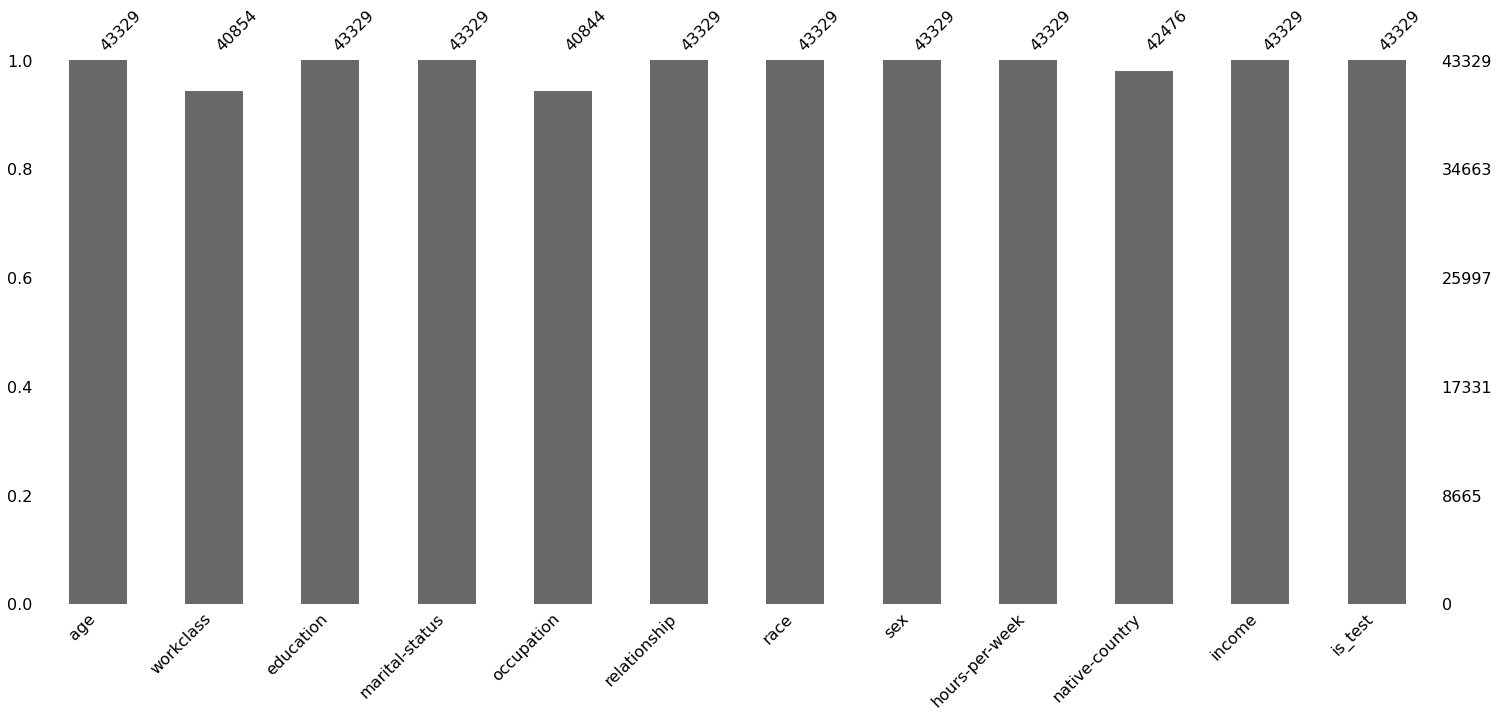

In [18]:
#visualiza a quantidade de registros nulos por atributo
msno.bar(data)

In [19]:
#total de registros nulos por atributo. 
data.isnull().sum()

age                  0
workclass         2475
education            0
marital-status       0
occupation        2485
relationship         0
race                 0
sex                  0
hours-per-week       0
native-country     853
income               0
is_test              0
dtype: int64

### Feature Engineering

#### Tratando dados faltantes
 - optaremos por três abordagens para o tratamento dos dados faltantes, visto que todos eles são categoricos.
 1. remoção dos registros que possuam pelo menos um dado faltante.
 2. preencher os dados faltantes pelo mais frequente na amostra (moda)
 3. preencher os dados faltantes por meio de um modelo de classificação (RandomForest ou LogistcRegression)
 
 - as abordagens 2 e 3 foram consideradas, uma vez que somente menos que 1% (30162/32561) da amostra possui dados faltantes.
 - para efeito de classificação, será considerada a abordagem que resultar no melhor desempenho dos modelos utilizados

In [20]:
#dropnulls | most_frequent | 
lang = "dropnulls"

match lang:
    case "dropnulls":
        data.dropna(axis=0, inplace=True)
        data.isnull().sum()
        print("nulos apagados")

    case "most_frequent":
        impute_mode = SimpleImputer(strategy = 'most_frequent')
        impute_mode.fit(data[['workclass', 'occupation','native-country']])
        data[['workclass', 'occupation','native-country']] = impute_mode.transform(df[['workclass', 'occupation','native-country']])
        print("nulos preenchidos com os registros mais frequentes")

    case _:
        # To perform KNN imputation, we need to normalize the input data and perform One Hot Encoding to categorical variables
        #from sklearn.impute import KNNImputer
        #imputer = KNNImputer(n_neighbors = 3)
        #df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
        #X = df.drop("workclass", axis=1).values
        #Y = df["workclass"].values
        #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
        #forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, max_features=0.6, min_samples_leaf=3, n_jobs=-1)
        #forest.fit(X_train, Y_train)
        print("nenhuma das opções válidas")

nulos apagados


<AxesSubplot:>

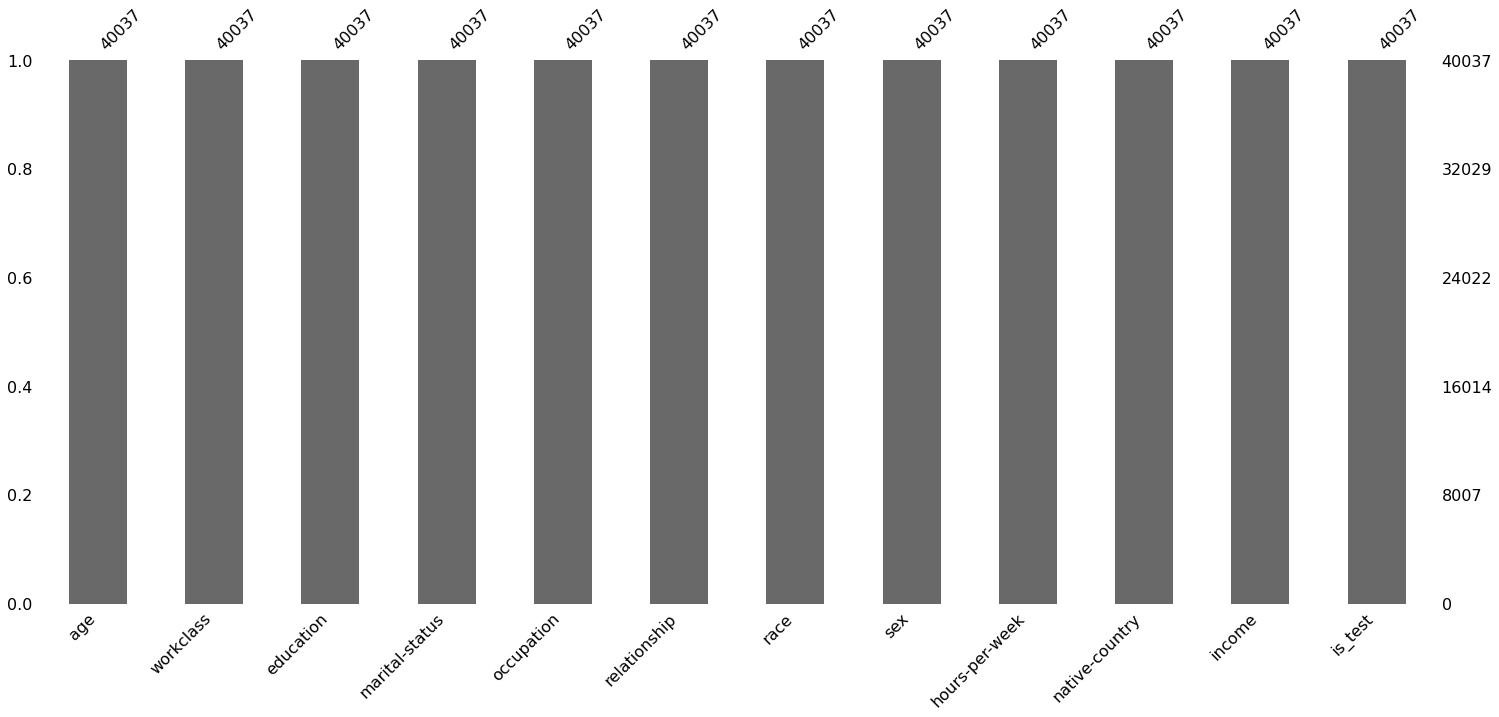

In [21]:
msno.bar(data)

#### Reestruturando atributos

In [22]:
data['fromUS'] = (data['native-country'] == 'United-States').astype(int)
data = data.drop('native-country', axis=1)

#### Registros de classificação impossível

In [23]:
all_columns = data.columns.tolist()
#exclui as variáveis target e de separação das amostras
predictor_columns = list(set(all_columns).difference([target_column,'is_test']))   
column_frequency = (data
    .groupby(predictor_columns, as_index=False)
    .agg({target_column: 'nunique'}))

column_frequency[column_frequency.income > 1].shape[0]

1347

In [24]:
#exemplo de um dos registros de treino impossível de classificar
impossible = data[(data['sex']=='Female') & (data['education']=='Assoc-acdm') & (data['workclass']=='Private') \
         & (data['marital-status']=='Divorced') & (data['occupation']=='Exec-managerial') \
         & (data['hours-per-week']==40)& (data['age']==40)& (data['marital-status']=='Divorced') ]
impossible

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,income,is_test,fromUS
13770,40,Private,Assoc-acdm,Divorced,Exec-managerial,Not-in-family,White,Female,40,0,0,1
26957,40,Private,Assoc-acdm,Divorced,Exec-managerial,Not-in-family,White,Female,40,1,0,1


In [25]:
predictor_columns

['race',
 'age',
 'marital-status',
 'fromUS',
 'relationship',
 'workclass',
 'hours-per-week',
 'education',
 'occupation',
 'sex']

In [26]:
data = data.drop_duplicates(subset=predictor_columns, keep=False)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33543 entries, 0 to 16280
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             33543 non-null  int64 
 1   workclass       33543 non-null  object
 2   education       33543 non-null  object
 3   marital-status  33543 non-null  object
 4   occupation      33543 non-null  object
 5   relationship    33543 non-null  object
 6   race            33543 non-null  object
 7   sex             33543 non-null  object
 8   hours-per-week  33543 non-null  int64 
 9   income          33543 non-null  int32 
 10  is_test         33543 non-null  int64 
 11  fromUS          33543 non-null  int32 
dtypes: int32(2), int64(3), object(7)
memory usage: 3.1+ MB


In [28]:
train_data, test_data = deduplicate(data)

In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11067 entries, 0 to 16280
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             11067 non-null  int64   
 1   workclass       11067 non-null  category
 2   education       11067 non-null  category
 3   marital-status  11067 non-null  category
 4   occupation      11067 non-null  category
 5   relationship    11067 non-null  category
 6   race            11067 non-null  category
 7   sex             11067 non-null  category
 8   hours-per-week  11067 non-null  int64   
 9   income          11067 non-null  int32   
 10  fromUS          11067 non-null  int32   
dtypes: category(7), int32(2), int64(2)
memory usage: 424.1 KB


In [30]:
data = data.reindex(columns=predictor_columns)

In [31]:
print("Total registros: {:d}, Treino: {:03d} e Teste: {:d}".format(data.shape[0], train_data.shape[0],test_data.shape[0]))

Total registros: 33543, Treino: 22476 e Teste: 11067


#### Identifica as covariáveis categóricas  e numéricas

In [32]:
# Armazena os atributos categóricos dentre os atributos preditores
cat_col=[]
for i in train_data.columns:
    if train_data[i].dtype=='category':
        cat_col.append(i)
cat_col

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex']

In [33]:
# Armazena os atributos numéricos dentre os atributos preditores
num_col=[]
for colname, column_series in train_data._get_numeric_data().items():
    num_col.append(colname)
    
num_col.remove(target_column)
num_col  

['age', 'hours-per-week', 'fromUS']

#### Encoding

In [34]:
def get_categorical_columns(data, cat_columns=None, fillna=True):
    if cat_columns is None:
        cat_data = data.select_dtypes('category')
    else:
        cat_data = data[cat_columns]

    if fillna:
        for colname, series in cat_data.iteritems():
            if 'Other' not in series.cat.categories:
                series = series.cat.add_categories(['Other'])

            cat_data[colname] = series.fillna('Other')
            
    return cat_data

In [35]:
def features_with_one_hot_encoded_categories(data, cat_columns=None, fillna=True):
    #cat_data = get_categorical_columns(data, cat_columns, fillna)
    cat_data = data[cat_columns]
    one_hot_data = pd.get_dummies(cat_data)
    df = pd.concat([data, one_hot_data], axis=1)

    features = [
        'age',
        #'education_num',
        'hours-per-week',
        #'capital_gain',
        #'capital_loss',
    ] + one_hot_data.columns.tolist()

    X = df[num_col].fillna(0).values.astype(float)
    y = df[target_column].values
    
    return X, y

In [36]:
X, y = features_with_one_hot_encoded_categories(train_data, cat_col)

### Aplicação Modelos

#### Linear model

The first model prototype will be build using logistic regression. This algorithm easier to debug and anylise. In addition, it provides good banchmark for future imrovements.

 **with only 3 numerical features**
 - age
 - hours-per-week
 - fromUS

Fold #1
ROC AUC score : 0.723
Kappa score   : 0.065
F1 score      : 0.122
Accuracy      : 0.770
------------------------------
Fold #2
ROC AUC score : 0.713
Kappa score   : 0.081
F1 score      : 0.152
Accuracy      : 0.780
------------------------------
Fold #3
ROC AUC score : 0.726
Kappa score   : 0.060
F1 score      : 0.123
Accuracy      : 0.763
------------------------------
Fold #4
ROC AUC score : 0.729
Kappa score   : 0.080
F1 score      : 0.142
Accuracy      : 0.772
------------------------------

Average ROC AUC across folds  : 0.723
Average Kappa across folds    : 0.072
Average F1 across folds       : 0.135
Average accuracy across folds : 0.771


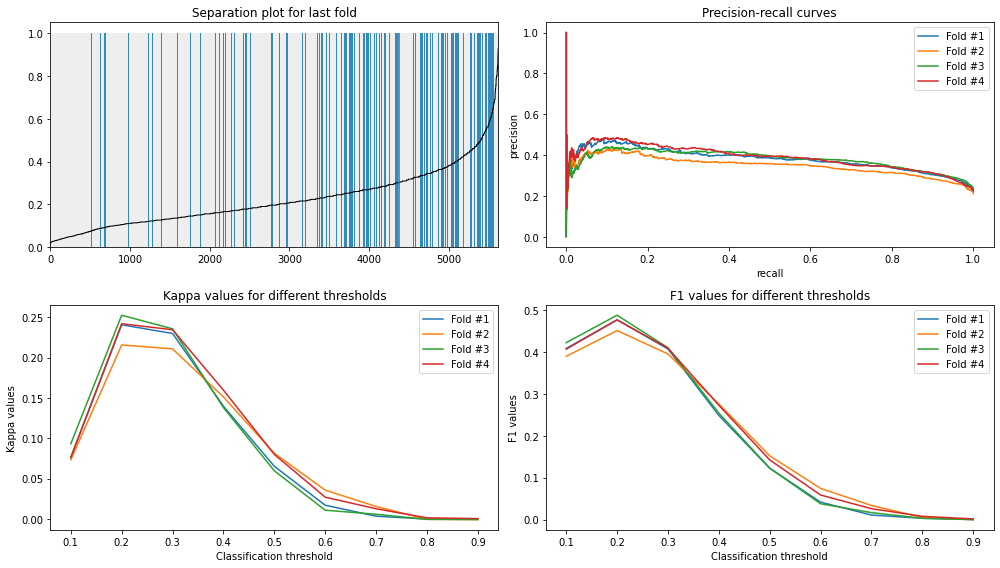

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X = train_data[num_col].values.astype(float)
y = train_data[target_column].values

model = Pipeline([
    # Scaling allows us to normalize variables. It will
    # make models coeficients interpratable.
    ('normalizer', StandardScaler()),
    ('classifier', LogisticRegression()),
])
validate_model(model, X, y)

Only 3 numerical columns give prediction with ROC AUC score almost equal to 0.8, which is a good start. On the other hand kappa and f1 scores are low. These score depend on the 0.5 threshold (unlike ROC AUC score) and it's just a bad choice for class separation. From the two lower plots we can see that F1 and Kappa scores can be improved if we pick threshold equal to 0.3.

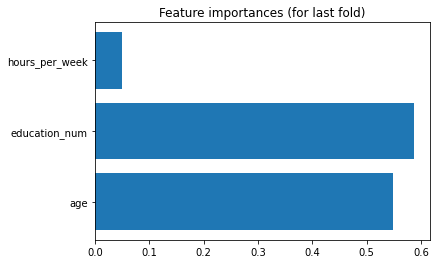

In [39]:
check_feature_importance(
    linear_classifier=model.named_steps['classifier'],
    feature_names=features,
)

#### Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier
X, y = features_with_one_hot_encoded_categories(train_data, cat_col)
model = DecisionTreeClassifier(
    min_samples_leaf=200,
    criterion='entropy',
)

Fold #1
ROC AUC score : 0.746
Kappa score   : 0.177
F1 score      : 0.282
Accuracy      : 0.775
------------------------------
Fold #2
ROC AUC score : 0.759
Kappa score   : 0.183
F1 score      : 0.287
Accuracy      : 0.775
------------------------------
Fold #3
ROC AUC score : 0.751
Kappa score   : 0.122
F1 score      : 0.203
Accuracy      : 0.773
------------------------------
Fold #4
ROC AUC score : 0.747
Kappa score   : 0.169
F1 score      : 0.264
Accuracy      : 0.783
------------------------------

Average ROC AUC across folds  : 0.751
Average Kappa across folds    : 0.163
Average F1 across folds       : 0.259
Average accuracy across folds : 0.776


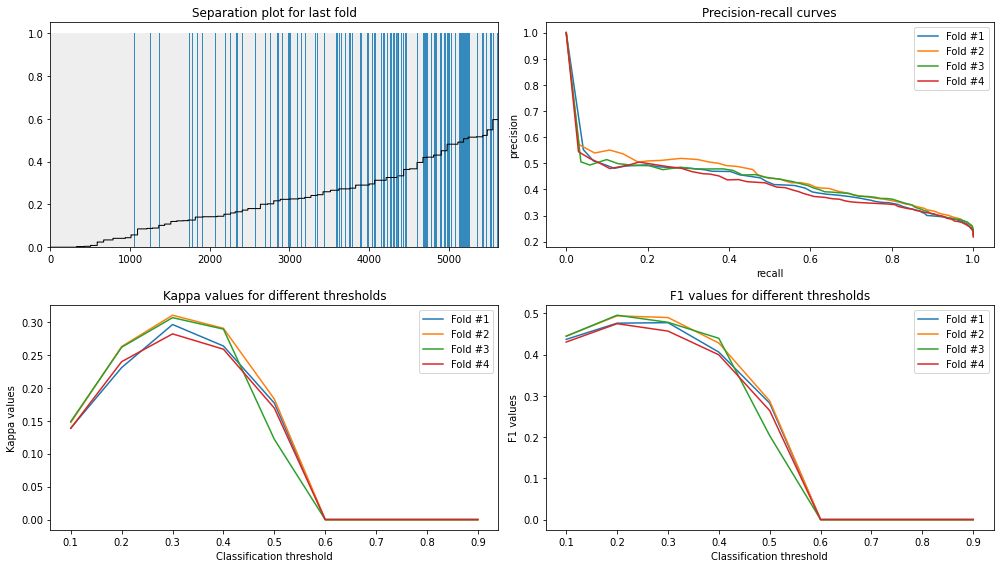

In [41]:
validate_model(model, X, y)

##### Categories labeled with integers

In [42]:
def features_with_labeled_categories(data, numerical_features, cat_columns=None, fillna=True):
    #cat_data = get_categorical_columns(data, cat_columns, fillna)
    cat_data = data[cat_columns]
    cat_labeled_data = cat_data.apply(lambda x: x.cat.codes)
    
    #numerical_features = [
    #    'age',
    #    'education_num',
    #    'hours_per_week',
    #    'capital_gain',
    #    'capital_loss',
    #]
    
    numerical_data = data[numerical_features]
    
    if fillna:
        numerical_data = numerical_data.fillna(0)
    
    X = np.concatenate([
        numerical_data.values.astype(float),
        cat_labeled_data.values,
    ], axis=1)
    y = data[target_column].values

    feature_names = numerical_features + cat_data.columns.tolist()
    return X, y, feature_names

Fold #1
ROC AUC score : 0.868
Kappa score   : 0.516
F1 score      : 0.617
Accuracy      : 0.840
------------------------------
Fold #2
ROC AUC score : 0.869
Kappa score   : 0.502
F1 score      : 0.606
Accuracy      : 0.835
------------------------------
Fold #3
ROC AUC score : 0.865
Kappa score   : 0.470
F1 score      : 0.581
Accuracy      : 0.823
------------------------------
Fold #4
ROC AUC score : 0.865
Kappa score   : 0.454
F1 score      : 0.557
Accuracy      : 0.830
------------------------------

Average ROC AUC across folds  : 0.867
Average Kappa across folds    : 0.486
Average F1 across folds       : 0.590
Average accuracy across folds : 0.832


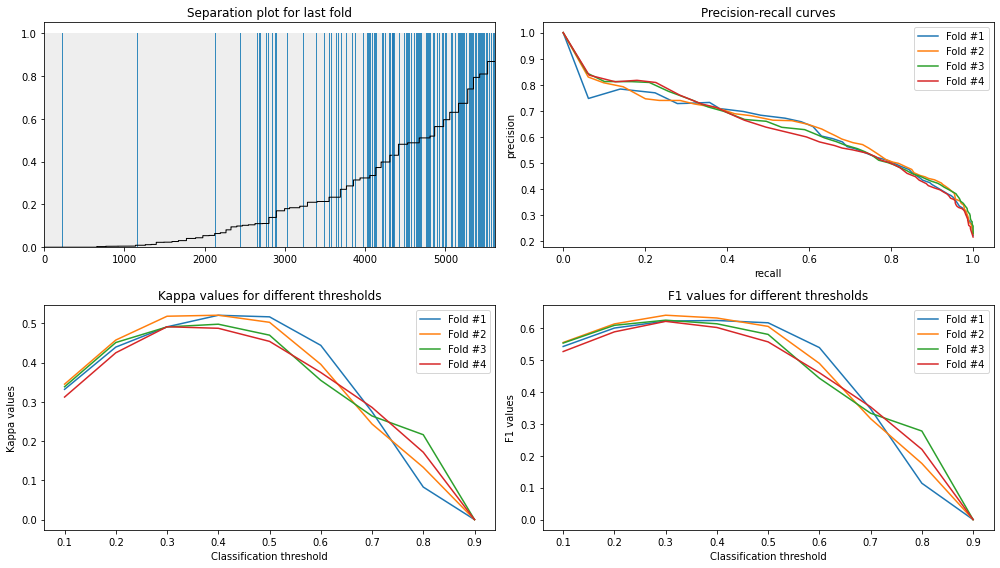

In [43]:
from sklearn.tree import DecisionTreeClassifier

X, y, feature_names = features_with_labeled_categories(train_data, num_col,cat_col)
model = DecisionTreeClassifier(
    min_samples_leaf=200,
    criterion='entropy',
)
validate_model(model, X, y)

#### Gradient Boosted Trees

C:\Users\CaioDaSilvaAzevedo\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\CaioDaSilvaAzevedo\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold #1
ROC AUC score : 0.750
Kappa score   : 0.175
F1 score      : 0.268
Accuracy      : 0.782
------------------------------
Fold #2
ROC AUC score : 0.739
Kappa score   : 0.139
F1 score      : 0.234
Accuracy      : 0.766
------------------------------


C:\Users\CaioDaSilvaAzevedo\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\CaioDaSilvaAzevedo\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold #3
ROC AUC score : 0.762
Kappa score   : 0.154
F1 score      : 0.235
Accuracy      : 0.788
------------------------------
Fold #4
ROC AUC score : 0.744
Kappa score   : 0.155
F1 score      : 0.248
Accuracy      : 0.777
------------------------------

Average ROC AUC across folds  : 0.749
Average Kappa across folds    : 0.156
Average F1 across folds       : 0.246
Average accuracy across folds : 0.778


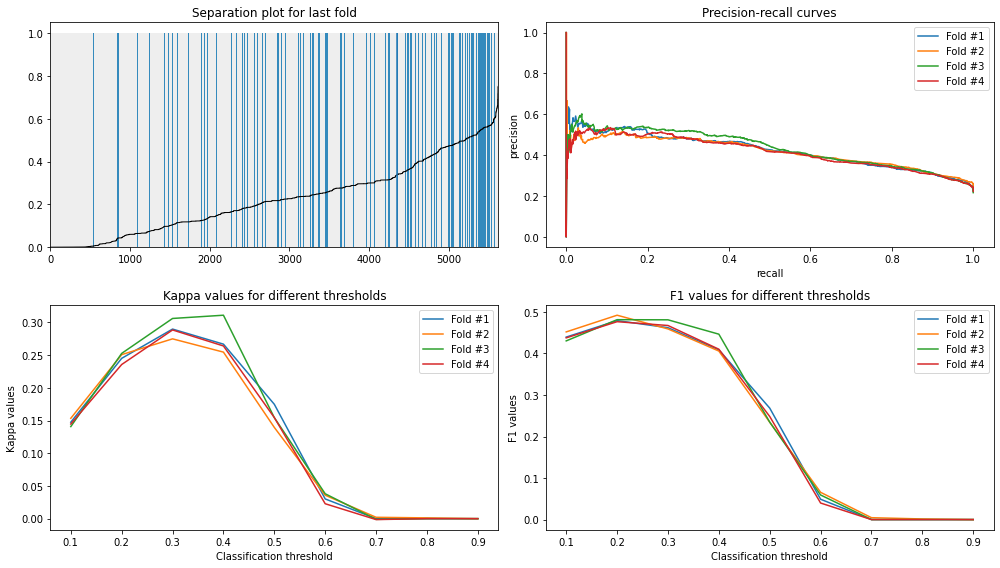

In [44]:
X, y = features_with_one_hot_encoded_categories(train_data, cat_col)
# Looks like default values give good enough result improvements
model = lgb.LGBMClassifier()
validate_model(model, X, y)

### Evaluating test dataset

In [45]:
n_train_samples = len(train_data)
fold_metrics = defaultdict(list)
# In every model probability threshold 0.3 and 0.4 showed best results
# For this reason we will use one threshold equal to 0.35
thresholds = np.array([0.35])
data = pd.concat([train_data, test_data], ignore_index=True)
X, y, feature_names = features_with_labeled_categories(data, num_col,cat_col)
X_train, y_train = X[:n_train_samples], y[:n_train_samples]
X_test, y_test = X[n_train_samples:], y[n_train_samples:]

In [46]:
len(X_test)

11067

In [47]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_predicted_probas = model.predict_proba(X_test)
y_predicted_proba = y_predicted_probas[:, 1]

collect_metrics(fold_metrics, y_test, y_predicted_proba, thresholds)
print_last_fold_stats(fold_metrics)

ROC AUC score : 0.890
Kappa score   : 0.533
F1 score      : 0.626
Accuracy      : 0.850


## Analyze models decisions

In [48]:
import shap
shap.initjs()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


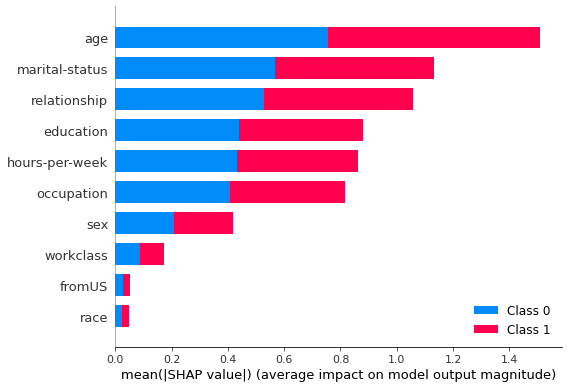

In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names)

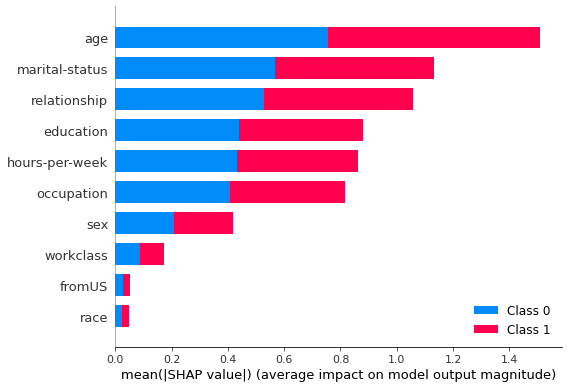

In [50]:
shap.summary_plot(shap_values, X, feature_names, plot_type='bar')

Observations:

The education column mostly duplicates information obtained from the education_num column, that's probably why it has low impact.

Native country contains mostly US and other countries probably don't have large impact on the outcome.

Race also looks like a strange variable to use for outcome prediction.

In [51]:
svc.score(X_train,y_train)

NameError: name 'svc' is not defined

In [ ]:
svc_pred = svc.predict(X_test)
accuracy_score(y_test,svc_pred)

Hyperparameter Tunning

In [ ]:
params = dict(kernel=['linear', 'poly'],C=[1,0.1,0.01])
Grid_model = GridSearchCV(svc,params,n_jobs=-1)
Grid_model.fit(X_train,y_train)
Grid_model.best_params_

In [ ]:
best_model = SVC(kernel='poly',gamma='scale',C=1).fit(X_train,y_train)

In [ ]:
best_model.score(X_train,y_train)

In [ ]:
best_pred = best_model.predict(X_test)

In [ ]:
accuracy_score(y_test,best_pred)